This does not have a reward for each individual turn. Just plays out d cycles of turns and uses the evaluation function at end.

In [14]:
from utils.game_map_class import GameMap
from utils.game_team_class import GameTeam
from utils.strategy_class import Strategy, RandomStrategy, RuleOfThumbStrategy
from utils.map_setup_functions import setGameBoardRandom, initializeFullRiskMap
from utils.heuristics import BST_Heuristic, EdgeWin

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import copy

In [4]:
def rollout_lookahead(team,riskMap,d,discount):
    '''Returns the best action according to lookahead with rollouts'''
    return greedy(team,riskMap,d,discount)[0]

In [5]:
def greedy(team,riskMap,d,discount):
    '''Greedily looks through all possible actions and determines the value of each from the current state
    using lookahead with rollouts. Returns action with maximum value and the value itself'''
    possible_attackers = team.getPossibleAttacks()
    print(possible_attackers)
    lookahead_list = []
    for attacker in possible_attackers:
        for defender in possible_attackers[attacker]:
            action = (attacker,defender)
            u = lookahead(discount,riskMap,action,d)
            lookahead_list.append((action,u))
    print(lookahead_list)
    if len(lookahead_list) == 0:
        return (None,None)
    return max(lookahead_list, key = lambda x: x[1])

In [6]:
def lookahead(discount,riskMap,action,d):
    ''' Computes successor states and probabilities of these successor states given the current riskMap
    
    Then for each of these successor states performs a rollout to get a value that that successor state and 
    multiplies it by the probability of that successor state. Takes the sum of those values and multiplies it
    by the discount factor to return the value of that function.
    '''
    
    # Gets basic information about current state of play
    attacking_territory, defending_territory = action
    num_attackers = riskMap.getTroops(attacking_territory)
    num_defenders = riskMap.getTroops(defending_territory)
    
    # Computes successor states and transition probabilities
    succ_state_probs = {}
    compute_succ_state_prob(1,num_attackers,num_defenders,succ_state_probs)
    
    sum_successors = 0
    for succ in succ_state_probs:
        
        # Sets up successor state
        sp = copy.deepcopy(riskMap)
        # Doing a deepcopy of the riskMap also makes copies of the GameTeams stored within the map in riskMap.teams
        # so we don't have to make another copy
        attacking_team = sp.getTeam(attacking_territory)
        defending_team = sp.getTeam(defending_territory)
        set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory)
        
        # Gets value of successor state via rollout and multiplies by the transition probability to add to sum
        prob = succ_state_probs[succ]
        sum_successors += prob*rollout(discount,sp,d,attacking_team,defending_team)
        
    return discount*sum_successors

In [7]:
def compute_succ_state_prob(prob,num_attackers,num_defenders,succ_state_probs):
    """This recursive function run to completion is meant to take prob = 1 and a number of attackers
    and defenders for a battle and update the succ_state_probs dictionary with the possible outcomes mapped
    to their respective probabilities."""
    if num_attackers == 0 or num_attackers == 1 or num_defenders == 0:
        if (num_attackers,num_defenders) in succ_state_probs:
            succ_state_probs[(num_attackers,num_defenders)] += prob
        else:
            succ_state_probs[(num_attackers,num_defenders)] = prob
    if num_attackers == 2 and num_defenders == 1:
        compute_succ_state_prob(prob*5/12,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*7/12,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders == 1:
        compute_succ_state_prob(prob*125/216,num_attackers,num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*91/216,num_attackers - 1,num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders == 1:
        compute_succ_state_prob(prob*95/144,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*49/144,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 2 and num_defenders > 1:
        compute_succ_state_prob(prob*55/216,num_attackers, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*161/216,num_attackers - 1, num_defenders,succ_state_probs)
    if num_attackers == 3 and num_defenders > 1:
        compute_succ_state_prob(prob*295/1296,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*35/108,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*581/1296,num_attackers - 2, num_defenders,succ_state_probs)
    if num_attackers > 3 and num_defenders > 1:
        compute_succ_state_prob(prob*1445/3888,num_attackers, num_defenders - 2,succ_state_probs)
        compute_succ_state_prob(prob*2611/7776,num_attackers - 1, num_defenders - 1,succ_state_probs)
        compute_succ_state_prob(prob*2275/7776,num_attackers - 2, num_defenders,succ_state_probs)

In [8]:
def set_up_sp(sp,succ,attacking_team,defending_team,attacking_territory,defending_territory):
    '''Sets up a successor state'''
    succ_num_attackers, succ_num_defenders = succ

    attacking_team.setTroops(attacking_territory, succ_num_attackers)
    defending_team.setTroops(defending_territory, succ_num_defenders)

    # Do not need to consider succ_num_attackers == 1 because we've already set the number of troops to be 1 above
    
    if succ_num_defenders == 0:

        # Declare the territory to the attacking team! 
        sp.setTeam(defending_territory, attacking_team.name)
        # Assign the territory to the attacking team
        attacking_team.addTerritory(defending_territory)
        defending_team.removeTerritory(defending_territory)

        # Move all but one remaining attacking troops to the territory
        attacking_team.moveTroops(attacking_territory, defending_territory, succ_num_attackers - 1)

In [22]:
def rollout(discount,sp,d,my_team,opponent):
    '''Rolls out using a stochastic policy (this is encoded in the strategy of my_team itself) against player. 
    Repeats rounds of turns to depth. If my_team wins, the reward is 100. If the opponent wins, the reward is 0.
    Otherwise, at the end of the rollout, we use the BST heuristic for both teams and the reward. We see what percentage
    of BTS between the two teams is attributed to the opponent (would be good for my_team) and use that as the reward'''
    ret = 0
    end_reached = False
    for t in range(d):
        if my_team.hasTeamWon():
            r = 100
            return (discount**t)*r
        opponent.playTurn()
        if opponent.hasTeamWon():
            r = -1
            return (discount**t)*r
        my_team.playTurn()
    if my_team.hasTeamWon():
        r = 100
        return (discount**(d-1))*r
    elif opponent.hasTeamWon():
        r = -1
        return (discount**(d-1))*r
    else:
        #print(BST_Heuristic(my_team,sp))
        #BST_my_team_sum = sum(list(BST_Heuristic(my_team,sp).values()))
        #BST_opponent_sum = sum(list(BST_Heuristic(opponent,sp).values()))
        #r = 100*BST_opponent_sum/(BST_my_team_sum+BST_opponent_sum)
        r = 100*EdgeWin(my_team,sp)
        return (discount**(d-1))*r

In [16]:
full_risk_map = initializeFullRiskMap()
team_names = ["rollout_team","rollout_opponent"]
team_strategies = [RandomStrategy,RuleOfThumbStrategy]
risk_map, teams = setGameBoardRandom(team_names, full_risk_map, team_strategies)
teams[1].getPossibleAttacks()

{}

Adding 1 to Western Australia!
Adding 1 to Venezuela!
Adding 1 to Ontario!
Adding 1 to Western Australia!
Adding 1 to Scandinavia!
Adding 1 to Scandinavia!
Adding 1 to Argentina!
('Scandinavia', ['Iceland'])
('Scandinavia', 'Iceland')
Team rollout_team declares attack on Team rollout_opponent from Scandinavia to Iceland
Attacking_dice:  [6, 2]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Western Australia', ['Indonesia', 'New Guinea', 'Eastern Australia'])
('Western Australia', 'Eastern Australia')
Team rollout_team declares attack on Team rollout_opponent from Western Australia to Eastern Australia
Attacking_dice:  [6, 2]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Eastern Australia', ['New Guinea'])
('Eastern Australia', 'New Guinea')
Team rollout_team declares attack on Team rollout_opponent from Eastern Australia to New Guinea
Attacking_dice:  [5]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  2
Defe

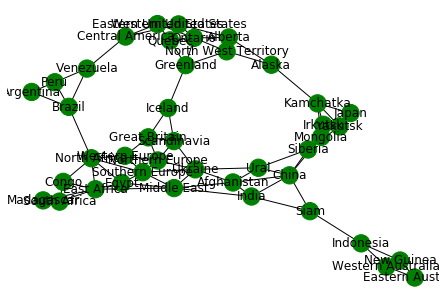

In [17]:
curr_team = teams[0]
defending_team = teams[1]
counter = 0
while len(teams[0].getPossibleAttacks())==0:
    curr_team.playTurn()
    curr_team_temp = curr_team
    curr_team = defending_team
    defending_team = curr_team_temp
    color_map = risk_map.getTeamColorMap()
    nx.draw(risk_map.graph, node_color = color_map, with_labels=True)
    plt.show()
    counter += 1

In [18]:
teams[0].getPossibleAttacks()

{'Argentina': ['Peru'],
 'Venezuela': ['Peru'],
 'Ontario': ['Western United States', 'Eastern United States']}

In [24]:
rollout_lookahead(teams[0],risk_map,30,.95)

{'Argentina': ['Peru'], 'Venezuela': ['Peru'], 'Ontario': ['Western United States', 'Eastern United States']}
65.21739130434783
Adding 5 to Middle East!
('Middle East', 'Egypt')
Team rollout_opponent declares attack on Team rollout_team from Middle East to Egypt
Attacking_dice:  [6, 5, 2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [5, 3, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
('Egypt', 'East Africa')
Team rollout_opponent declares attack on Team rollout_team from Egypt to East Africa
Attacking_dice:  [5, 4, 3]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  4
Defending Troops Left:  0
Adding 1 to Northern Europe!
Adding 1 to North West Territory!
Adding 1 to Mongolia!
Adding 1 to Argentina!
Adding 1 to Ukraine!
Adding 1 to Quebec!
Adding 1 to Ukraine!
('Mongolia', ['Siberia', 'China', 'Kamchatka'])
('Mongolia', 'Siberia')
Team rollout_team declares attack on Team rollout_opponent fr

[ True]
Attacking Troops Left:  14
Defending Troops Left:  0
('Brazil', 'Venezuela')
Team rollout_opponent declares attack on Team rollout_team from Brazil to Venezuela
Attacking_dice:  [6, 4, 1]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  13
Defending Troops Left:  0
('Venezuela', 'Central America')
Team rollout_opponent declares attack on Team rollout_team from Venezuela to Central America
Attacking_dice:  [3, 2, 1]
Defending_dice:  [3]
[False]
Attacking Troops Left:  11
Defending Troops Left:  1
Attacking_dice:  [3, 2, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  11
Defending Troops Left:  0
('Central America', 'Eastern United States')
Team rollout_opponent declares attack on Team rollout_team from Central America to Eastern United States
Attacking_dice:  [6, 3, 1]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  10
Defending Troops Left:  0
Adding 1 to North Africa!
Adding 1 to North Africa!
Adding 1 to Scandinavia!
('Irkutsk', ['Yakutsk', 'Kamchatka', 'Mong

Defending_dice:  [3, 2]
[ True  True]
Attacking Troops Left:  11
Defending Troops Left:  1
Attacking_dice:  [4, 3, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  11
Defending Troops Left:  0
('Greenland', 'Iceland')
Team rollout_opponent declares attack on Team rollout_team from Greenland to Iceland
Attacking_dice:  [3, 2, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  10
Defending Troops Left:  0
('Iceland', 'Great Britain')
Team rollout_opponent declares attack on Team rollout_team from Iceland to Great Britain
Attacking_dice:  [5, 3, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  9
Defending Troops Left:  0
('Great Britain', 'Northern Europe')
Team rollout_opponent declares attack on Team rollout_team from Great Britain to Northern Europe
Attacking_dice:  [5, 4, 1]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  8
Defending Troops Left:  0
('Northern Europe', 'Ukraine')
Team rollout_opponent declares attack on Team rollout_team from Northern Europe to

Defending Troops Left:  0
('Greenland', 'North West Territory')
Team rollout_opponent declares attack on Team rollout_team from Greenland to North West Territory
Attacking_dice:  [4]
Defending_dice:  [6]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
Adding 1 to Central America!
Adding 1 to Brazil!
Adding 1 to Peru!
Adding 1 to Iceland!
Adding 1 to Scandinavia!
('Western Australia', ['Indonesia'])
('Western Australia', 'Indonesia')
Team rollout_team declares attack on Team rollout_opponent from Western Australia to Indonesia
Attacking_dice:  [5, 3, 1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  3
Defending Troops Left:  1
Attacking_dice:  [5, 3]
Defending_dice:  [5]
[False]
Attacking Troops Left:  2
Defending Troops Left:  1
Attacking_dice:  [6]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('Central America', ['Western United States', 'Eastern United States'])
('Central America', 'Eastern United States')
Team rollout_team declar

Attacking Troops Left:  11
Defending Troops Left:  1
Attacking_dice:  [6, 5, 3]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  11
Defending Troops Left:  0
Adding 1 to Indonesia!
Adding 1 to Eastern Australia!
Adding 1 to Western Australia!
('Indonesia', ['Siam'])
('Indonesia', 'Siam')
Team rollout_team declares attack on Team rollout_opponent from Indonesia to Siam
Attacking_dice:  [4]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
Adding 12 to China!
('China', 'Siam')
Team rollout_opponent declares attack on Team rollout_team from China to Siam
Attacking_dice:  [4, 3, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  22
Defending Troops Left:  0
('Siam', 'Indonesia')
Team rollout_opponent declares attack on Team rollout_team from Siam to Indonesia
Attacking_dice:  [6, 4, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  20
Defending Troops Left:  1
Attacking_dice:  [4, 2, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  20
De

Attacking_dice:  [6, 5, 1]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  8
Defending Troops Left:  0
('China', 'Ural')
Team rollout_opponent declares attack on Team rollout_team from China to Ural
Attacking_dice:  [6, 5, 2]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
Adding 1 to Western Australia!
Adding 1 to New Guinea!
Adding 1 to East Africa!
Adding 1 to Irkutsk!
('Japan', ['Mongolia', 'Kamchatka'])
('Japan', 'Kamchatka')
Team rollout_team declares attack on Team rollout_opponent from Japan to Kamchatka
Attacking_dice:  [3]
Defending_dice:  [3]
[False]
Attacking Troops Left:  1
Defending Troops Left:  1
('Irkutsk', ['Siberia', 'Yakutsk', 'Kamchatka', 'Mongolia'])
('Irkutsk', 'Mongolia')
Team rollout_team declares attack on Team rollout_opponent from Irkutsk to Mongolia
Attacking_dice:  [6, 2]
Defending_dice:  [4]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
('Mongolia', ['Siberia', 'China', 'Kamchatka'])
('Mongolia', 'Kamcha

Attacking_dice:  [6, 3, 2]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
('Southern Europe', 'Ukraine')
Team rollout_opponent declares attack on Team rollout_team from Southern Europe to Ukraine
Attacking_dice:  [6, 2, 1]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  4
Defending Troops Left:  0
('Ukraine', 'Ural')
Team rollout_opponent declares attack on Team rollout_team from Ukraine to Ural
Attacking_dice:  [5, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  3
Defending Troops Left:  0
Adding 1 to Great Britain!
Adding 1 to Central America!
Adding 1 to Siam!
Adding 1 to Argentina!
Adding 1 to Eastern Australia!
Adding 1 to Japan!
Adding 1 to Iceland!
('Central America', ['Eastern United States'])
('Central America', 'Eastern United States')
Team rollout_team declares attack on Team rollout_opponent from Central America to Eastern United States
Attacking_dice:  [4, 3]
Defending_dice:  [6]
[False]
Attacking Troops Left:  2
Defending Tro

Attacking Troops Left:  9
Defending Troops Left:  0
('East Africa', 'Middle East')
Team rollout_opponent declares attack on Team rollout_team from East Africa to Middle East
Attacking_dice:  [5, 3, 2]
Defending_dice:  [5, 2]
[False  True]
Attacking Troops Left:  7
Defending Troops Left:  1
Attacking_dice:  [6, 5, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  6
Defending Troops Left:  1
Attacking_dice:  [5, 2, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
('Middle East', 'Egypt')
Team rollout_opponent declares attack on Team rollout_team from Middle East to Egypt
Attacking_dice:  [6, 4, 3]
Defending_dice:  [5, 2]
[ True  True]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [6, 5, 3]
Defending_dice:  [6]
[False]
Attacking Troops Left:  4
Defending Troops Left:  1
Attacking_dice:  [6, 5, 1]
Defending_dice:  [6]
[False]
Attacking Troops Left:  3
Defending Troops Left:  1
Attacking_dice:  [4, 2]
Defending_dice:  [1]
[ Tru

Defending_dice:  [2]
[ True]
Attacking Troops Left:  9
Defending Troops Left:  0
Adding 1 to Great Britain!
Adding 1 to East Africa!
Adding 1 to Scandinavia!
Adding 1 to Western Europe!
('Scandinavia', ['Ukraine'])
('Scandinavia', 'Ukraine')
Team rollout_team declares attack on Team rollout_opponent from Scandinavia to Ukraine
Attacking_dice:  [3, 2, 1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  5
Defending Troops Left:  1
Attacking_dice:  [6, 3, 2]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  5
Defending Troops Left:  0
('Ukraine', ['Ural', 'Afghanistan', 'Middle East'])
('Ukraine', 'Ural')
Team rollout_team declares attack on Team rollout_opponent from Ukraine to Ural
Attacking_dice:  [4, 3, 1]
Defending_dice:  [5, 2]
[False  True]
Attacking Troops Left:  3
Defending Troops Left:  7
Attacking_dice:  [5, 3]
Defending_dice:  [5, 3]
[False False]
Attacking Troops Left:  1
Defending Troops Left:  7
('East Africa', ['Middle East', 'Madagascar', 'South Africa', 'Congo'])


('Ural', ['Afghanistan', 'Siberia', 'China'])
('Ural', 'Afghanistan')
Team rollout_team declares attack on Team rollout_opponent from Ural to Afghanistan
Attacking_dice:  [5]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  2
Defending Troops Left:  0
('India', ['Middle East', 'China', 'Siam'])
Adding 6 to Middle East!
('Middle East', 'East Africa')
Team rollout_opponent declares attack on Team rollout_team from Middle East to East Africa
Attacking_dice:  [6, 4, 3]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  7
Defending Troops Left:  0
('East Africa', 'Egypt')
Team rollout_opponent declares attack on Team rollout_team from East Africa to Egypt
Attacking_dice:  [6, 3, 2]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  6
Defending Troops Left:  0
Adding 1 to Scandinavia!
Adding 1 to New Guinea!
Adding 1 to India!
Adding 1 to Indonesia!
Adding 1 to Iceland!
Adding 1 to New Guinea!
Adding 1 to Mongolia!
('Mongolia', ['Siberia', 'China', 'Kamchatka'])
('Mongolia', 'Kamchat

Defending_dice:  [4, 2]
[ True  True]
Attacking Troops Left:  23
Defending Troops Left:  3
Attacking_dice:  [5, 4, 1]
Defending_dice:  [6, 1]
[False  True]
Attacking Troops Left:  22
Defending Troops Left:  2
Attacking_dice:  [6, 3, 1]
Defending_dice:  [2, 1]
[ True  True]
Attacking Troops Left:  22
Defending Troops Left:  0
('Brazil', 'Argentina')
Team rollout_opponent declares attack on Team rollout_team from Brazil to Argentina
Attacking_dice:  [6, 3, 2]
Defending_dice:  [6]
[False]
Attacking Troops Left:  20
Defending Troops Left:  1
Attacking_dice:  [4, 2, 1]
Defending_dice:  [5]
[False]
Attacking Troops Left:  19
Defending Troops Left:  1
Attacking_dice:  [6, 4, 2]
Defending_dice:  [5]
[ True]
Attacking Troops Left:  19
Defending Troops Left:  0
62.7906976744186
Adding 6 to Middle East!
('Middle East', 'Ukraine')
Team rollout_opponent declares attack on Team rollout_team from Middle East to Ukraine
Attacking_dice:  [6, 4, 2]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  7


Defending_dice:  [6, 4]
[False False]
Attacking Troops Left:  13
Defending Troops Left:  3
Attacking_dice:  [6, 3, 1]
Defending_dice:  [6, 1]
[False  True]
Attacking Troops Left:  12
Defending Troops Left:  2
Attacking_dice:  [5, 4, 3]
Defending_dice:  [6, 2]
[False  True]
Attacking Troops Left:  11
Defending Troops Left:  1
Attacking_dice:  [5, 2, 1]
Defending_dice:  [1]
[ True]
Attacking Troops Left:  11
Defending Troops Left:  0
('Alaska', 'Kamchatka')
Team rollout_opponent declares attack on Team rollout_team from Alaska to Kamchatka
Attacking_dice:  [6, 3, 2]
Defending_dice:  [3]
[ True]
Attacking Troops Left:  10
Defending Troops Left:  0
('Kamchatka', 'Yakutsk')
Team rollout_opponent declares attack on Team rollout_team from Kamchatka to Yakutsk
Attacking_dice:  [5, 3, 2]
Defending_dice:  [5]
[False]
Attacking Troops Left:  8
Defending Troops Left:  1
Attacking_dice:  [4, 3, 1]
Defending_dice:  [2]
[ True]
Attacking Troops Left:  8
Defending Troops Left:  0
[(('Argentina', 'Peru

('Argentina', 'Peru')

In [18]:
a = {1:2,2:3}
a.values()

dict_values([2, 3])